## Demo Notebook


### Basic usage

In [1]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter as draw

ghz_circ = Circuit(3).H(0).CX(0, 1).CX(0, 2)
ghz_circ.add_barrier([0, 1, 2])
ghz_circ.measure_all()

draw(ghz_circ)

In [2]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()

result = backend.run_circuit(ghz_circ)
print(result.get_counts())

Counter({(0, 0, 0): 514, (1, 1, 1): 510})


## Converting circuits (pytket<->qiskit)

* Note pytket and qiskit have different qubit ordering conventions. Be careful that your circuit corresponds to the desired unitary. (qiskit=little-endian, 
* If you get a `NotImplementedError` with `qiskit_to_tk` use `QuantumCircuit.decompose()` and try again

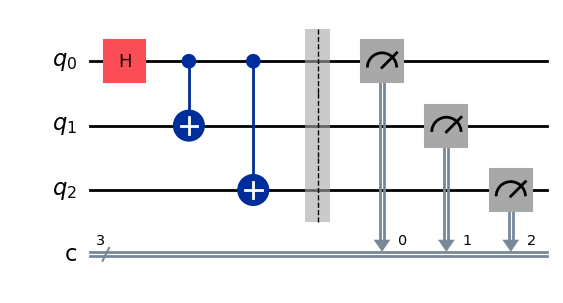

In [3]:
from pytket.extensions.qiskit import tk_to_qiskit

qiskit_ghz = tk_to_qiskit(ghz_circ)

qiskit_ghz.draw("mpl")

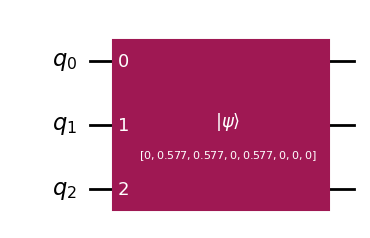

In [4]:
from qiskit import QuantumCircuit
from pytket.extensions.qiskit import qiskit_to_tk
import numpy as np

qiskit_qc = QuantumCircuit(3)

w_state = 1 / np.sqrt(3) * np.array([0, 1, 1, 0, 1, 0, 0, 0])

qiskit_qc.initialize(w_state)
qiskit_qc.draw("mpl")

In [5]:
pytket_w_state_circ = qiskit_to_tk(qiskit_qc)
draw(pytket_w_state_circ)

## Compiling to real device architectures

* Configure your qiskit credentials -> https://tket.quantinuum.com/extensions/pytket-qiskit/#access-and-credentials
* Compile and run circuits on any publically available IBM device
* Use `IBMQEmulatorBackend` for a local simulation with a Noise model.

In [6]:
#from qiskit_ibm_provider import IBMProvider
#from qiskit_ibm_runtime import QiskitRuntimeService

#IBMProvider.save_account(token=ibm_token)
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=ibm_token)

from pytket.extensions.qiskit import IBMQBackend

backend_name = "ibm_brisbane"

brisbane_backend = IBMQBackend(backend_name)

In [7]:
compiled_ghz =  brisbane_backend.get_compiled_circuit(ghz_circ)
draw(compiled_ghz)

## pytket compilation vs qiskit?

Compile all-to-all QFT circuit and compare

Reminder: Quantum Fourier Transform has $\frac{n(n-1)}{2}$ controlled $U1$ rotations, $n$ Hadamard gates and $\lfloor\frac{n}{2}\rfloor$ SWAP gates

Tutorial notebook on QFT and QPE -> https://tket.quantinuum.com/examples/phase_estimation.html




In [8]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [9]:
qft3_circ = build_qft_circuit(3)
draw(qft3_circ)

In [10]:
qft32_circ_pytket = build_qft_circuit(32)

#draw(qft32_circ)

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import warnings


warnings.filterwarnings('ignore')

service = QiskitRuntimeService()
backend = service.backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

In [12]:
qft32_qiskit = tk_to_qiskit(qft32_circ_pytket)

In [13]:
import time
import warnings
warnings.filterwarnings('ignore')


t1 = time.perf_counter()
compiled_qiskit_qft = pass_manager.run(qft32_qiskit)
t2 = time.perf_counter()

print(t2-t1)

qiskit_ops = compiled_qiskit_qft.count_ops()

print(qiskit_ops)

32.37436070900003
OrderedDict([('rz', 7957), ('sx', 4994), ('ecr', 2284), ('x', 729)])


In [14]:
from pytket.utils.stats import gate_counts


t1_pytket = time.perf_counter()
compilied_qft_pytket = brisbane_backend.get_compiled_circuit(
    qft32_circ_pytket, optimisation_level=2
)
t2_pytket = time.perf_counter()

pytket_gate_counts = gate_counts(compilied_qft_pytket)

print(pytket_gate_counts)
print(t2_pytket - t1_pytket)


Counter({<OpType.Rz: 36>: 3975, <OpType.SX: 31>: 3094, <OpType.X: 23>: 2366, <OpType.ECR: 66>: 2043})
18.945027333989856


In [15]:
from pytket import OpType
ecr_percentage_diff = ((qiskit_ops["ecr"] - pytket_gate_counts[OpType.ECR])/ qiskit_ops["ecr"]) * 100
print(round(ecr_percentage_diff, 2),"%")

10.55 %


## Swapping to the `QuantinuumBackend`


In [16]:
from pytket.extensions.quantinuum import QuantinuumBackend

h2_backend = QuantinuumBackend("H2-1")

compiled_qft_h2 = h2_backend.get_compiled_circuit(qft32_circ_pytket, optimisation_level=2)

gate_counts(compiled_qft_h2)

Enter your Quantinuum email:  callum.macpherson@quantinuum.com
Enter your Quantinuum password:  ········


Counter({<OpType.PhasedX: 68>: 895,
         <OpType.ZZPhase: 73>: 661,
         <OpType.Rz: 36>: 32})

In [17]:
draw(compiled_qft_h2)

## Thanks for listening

* Slack channel click here ->  [![Slack](https://img.shields.io/badge/Slack-4A154B?style=for-the-badge&logo=slack&logoColor=white)](https://tketusers.slack.com/join/shared_invite/zt-18qmsamj9-UqQFVdkRzxnXCcKtcarLRA#)

* [Stack exchange tag for pytket](https://quantumcomputing.stackexchange.com/questions/tagged/pytket) 